### Load Modules

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split

### Collect & Prepare Data

In [2]:
TEST_DIR = 'brain_tumor/Testing/'
TRAIN_DIR = 'brain_tumor/Training/'
IMG_SIZE = 128
CATEGORIES = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]

In [3]:
def load_data(directory):
    data = []
    for category in CATEGORIES:
        path = os.path.join(directory, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([new_array, class_num])
            except Exception as e:
                pass
    return data

In [4]:
training_data = load_data(TRAIN_DIR)
testing_data = load_data(TEST_DIR)

In [5]:
X_train = np.array([i[0] for i in training_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_train = np.array([i[1] for i in training_data])
X_test = np.array([i[0] for i in testing_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_test = np.array([i[1] for i in testing_data])

In [6]:
X_train = X_train / 255.0
X_test = X_test / 255.0

### Split Data

In [7]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

### Train Model

In [8]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

In [9]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
history = model.fit(X_train, Y_train, batch_size=32, epochs=50,
                    validation_data=(X_val, Y_val))

Epoch 1/50


72/72 [==============================] - 18s 239ms/step - loss: 1.0175 - accuracy: 0.5640 - val_loss: 0.7001 - val_accuracy: 0.7213
Epoch 2/50
72/72 [==============================] - 17s 238ms/step - loss: 0.6262 - accuracy: 0.7321 - val_loss: 0.5365 - val_accuracy: 0.8031
Epoch 3/50
72/72 [==============================] - 17s 242ms/step - loss: 0.4463 - accuracy: 0.8227 - val_loss: 0.4807 - val_accuracy: 0.8206
Epoch 4/50
72/72 [==============================] - 17s 242ms/step - loss: 0.3197 - accuracy: 0.8772 - val_loss: 0.4235 - val_accuracy: 0.8240
Epoch 5/50
72/72 [==============================] - 18s 245ms/step - loss: 0.2206 - accuracy: 0.9207 - val_loss: 0.4464 - val_accuracy: 0.8502
Epoch 6/50
72/72 [==============================] - 18s 250ms/step - loss: 0.1723 - accuracy: 0.9416 - val_loss: 0.3749 - val_accuracy: 0.8606
Epoch 7/50
72/72 [==============================] - 18s 250ms/step - loss: 0.1251 - accuracy: 0.9547 - val_loss: 0.3651 - val_accuracy: 0.88

In [11]:
selected_folder = "brain_tumor/Testing/glioma_tumor"  
image_files = os.listdir(selected_folder)

selected_image_filename = image_files[7] 

selected_image_path = os.path.join(selected_folder, selected_image_filename)
selected_image = cv2.imread(selected_image_path)
selected_image = cv2.resize(selected_image, (IMG_SIZE, IMG_SIZE))  
selected_image = selected_image / 255.0  

selected_image = selected_image.reshape(1, IMG_SIZE, IMG_SIZE, 3)

predictions = model.predict(selected_image)

predicted_class_index = np.argmax(predictions)
predicted_class = CATEGORIES[predicted_class_index]

print("Predicted class:", predicted_class)

1/1 [==============================] - 0s 127ms/step
Predicted class: glioma_tumor


In [12]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)
svm_classifier.fit(X_train_flat, Y_train)

SVC(kernel='linear', random_state=42)

In [13]:
selected_folder = "brain_tumor/Testing/meningioma_tumor"  
image_files = os.listdir(selected_folder)

selected_image_filename = image_files[78] 

selected_image_path = os.path.join(selected_folder, selected_image_filename)
selected_image = cv2.imread(selected_image_path)
selected_image = cv2.resize(selected_image, (IMG_SIZE, IMG_SIZE))  
selected_image = selected_image / 255.0  
selected_image_flat = selected_image.reshape(1, -1) 

svm_predicted_class_index = svm_classifier.predict(selected_image_flat)[0]
svm_predicted_class = CATEGORIES[svm_predicted_class_index]

print("Predicted class:", svm_predicted_class)

Predicted class: meningioma_tumor


In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

pca = PCA(n_components=100) 
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

knn_grid = GridSearchCV(KNeighborsClassifier(), {'n_neighbors': [3, 5, 7]}, cv=5)
knn_grid.fit(X_train_pca, Y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7]})

In [15]:
selected_folder = "brain_tumor/Testing/no_tumor"  
image_files = os.listdir(selected_folder)

selected_image_filename = image_files[39] 

selected_image_path = os.path.join(selected_folder, selected_image_filename)
selected_image = cv2.imread(selected_image_path)
selected_image = cv2.resize(selected_image, (IMG_SIZE, IMG_SIZE))  
selected_image = selected_image / 255.0  
selected_image_flat = selected_image.reshape(1, -1) 
selected_image_pca = pca.transform(selected_image_flat)

knn_best_model = knn_grid.best_estimator_

knn_predicted_class_index = knn_best_model.predict(selected_image_pca)[0]
knn_predicted_class = CATEGORIES[knn_predicted_class_index]

print("Predicted class:", knn_predicted_class)

Predicted class: no_tumor


In [16]:
from sklearn.ensemble import RandomForestClassifier

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_flat, Y_train)

RandomForestClassifier(random_state=42)

In [17]:
selected_folder = "brain_tumor/Testing/pituitary_tumor"  
image_files = os.listdir(selected_folder)

selected_image_filename = image_files[17] 

selected_image_path = os.path.join(selected_folder, selected_image_filename)
selected_image = cv2.imread(selected_image_path)
selected_image = cv2.resize(selected_image, (IMG_SIZE, IMG_SIZE))  
selected_image = selected_image / 255.0  
selected_image_flat = selected_image.reshape(1, -1)  

rf_predicted_class_index = rf_classifier.predict(selected_image_flat)[0]
rf_predicted_class = CATEGORIES[rf_predicted_class_index]

print("Predicted class:", rf_predicted_class)

Predicted class: pituitary_tumor


In [18]:
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_flat, Y_train)

DecisionTreeClassifier(random_state=42)

In [19]:
selected_folder = "brain_tumor/Testing/meningioma_tumor"  
image_files = os.listdir(selected_folder)

selected_image_filename = image_files[55] 

selected_image_path = os.path.join(selected_folder, selected_image_filename)
selected_image = cv2.imread(selected_image_path)
selected_image = cv2.resize(selected_image, (IMG_SIZE, IMG_SIZE))  
selected_image = selected_image / 255.0  
selected_image_flat = selected_image.reshape(1, -1)  

dt_predicted_class_index = dt_classifier.predict(selected_image_flat)[0]
dt_predicted_class = CATEGORIES[dt_predicted_class_index]

print("Predicted class:", dt_predicted_class)

Predicted class: meningioma_tumor


### Evaluation

In [20]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print("Testing Loss:", test_loss)
print("Testing Accuracy:", test_accuracy)

8/8 [==============================] - 1s 56ms/step - loss: 0.5036 - accuracy: 0.9409
Testing Loss: 0.5036188960075378
Testing Accuracy: 0.9409449100494385


In [21]:
svm_pred = svm_classifier.predict(X_test_flat)
svm_accuracy = accuracy_score(Y_test, svm_pred)
print("SVM Accuracy:", svm_accuracy)

SVM Accuracy: 0.9212598425196851


In [22]:
knn_best_model = knn_grid.best_estimator_
knn_accuracy = knn_best_model.score(X_test_pca, Y_test)
print("KNN Accuracy:", knn_accuracy)

KNN Accuracy: 0.7244094488188977


In [23]:
rf_pred = rf_classifier.predict(X_test_flat)
rf_accuracy = accuracy_score(Y_test, rf_pred)
print("Random Forest Accuracy:", rf_accuracy)

Random Forest Accuracy: 0.8661417322834646


In [24]:
dt_pred = dt_classifier.predict(X_test_flat)
dt_accuracy = accuracy_score(Y_test, dt_pred)
print("Decision Tree Accuracy:", dt_accuracy)

Decision Tree Accuracy: 0.8700787401574803


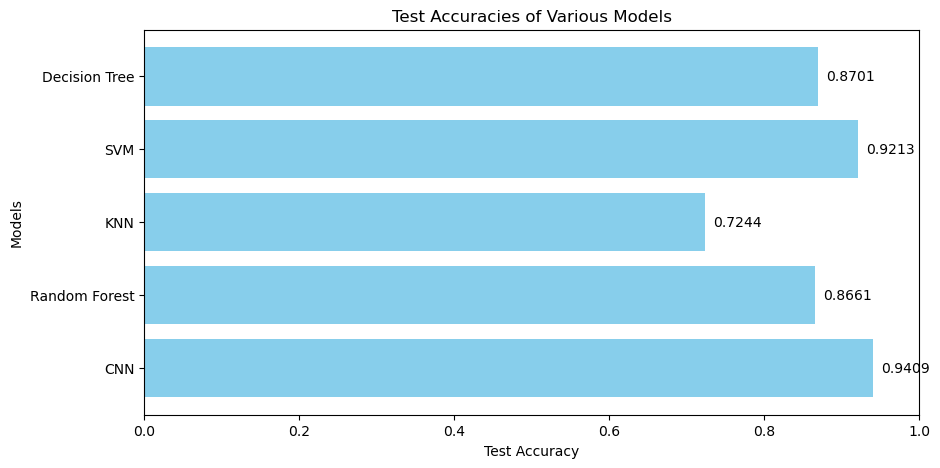

In [25]:
import matplotlib.pyplot as plt

accuracies = [test_accuracy, rf_accuracy, knn_accuracy, svm_accuracy, dt_accuracy]

models = ['CNN', 'Random Forest', 'KNN', 'SVM', 'Decision Tree']

plt.figure(figsize=(10, 5))
plt.barh(models, accuracies, color='skyblue')
plt.xlabel('Test Accuracy')
plt.ylabel('Models')
plt.title('Test Accuracies of Various Models')
plt.xlim(0, 1)
for i, accuracy in enumerate(accuracies):
    plt.text(accuracy + 0.01, i, f'{accuracy:.4f}', va='center')
plt.show()

8/8 [==============================] - 0s 52ms/step


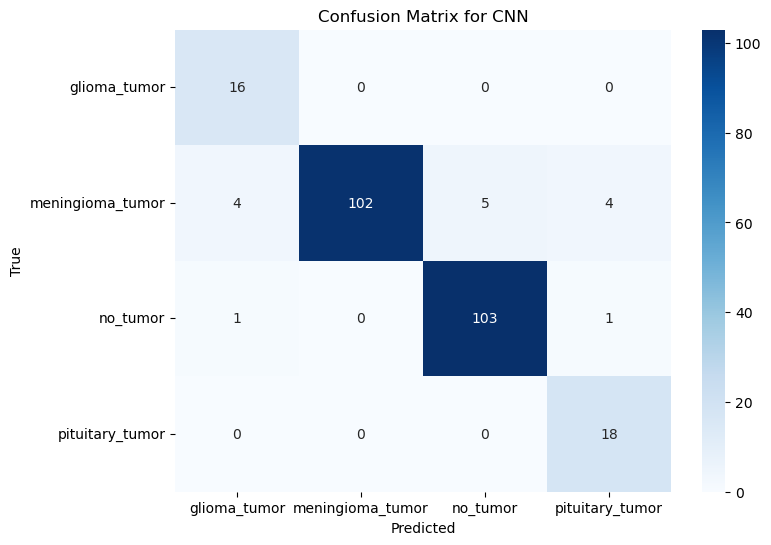

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Y_pred = np.argmax(model.predict(X_test), axis=-1)
cnn_cm = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for CNN')
plt.show()

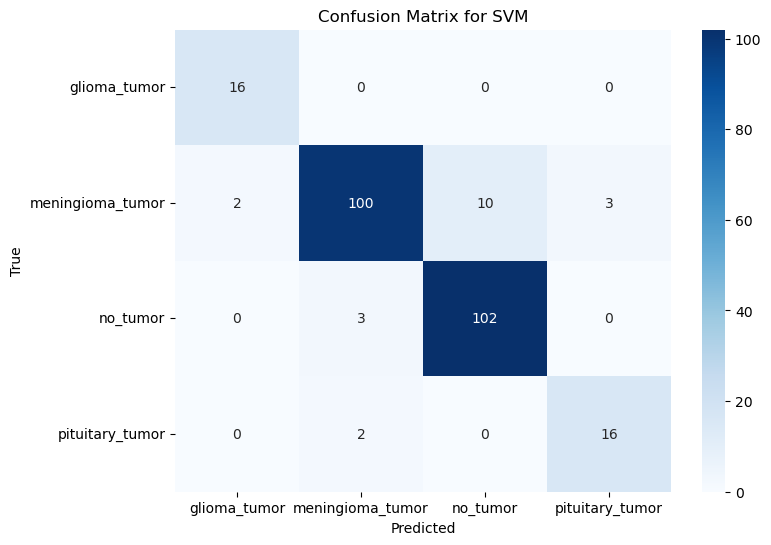

In [27]:
svm_cm = confusion_matrix(Y_test, svm_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for SVM')
plt.show()

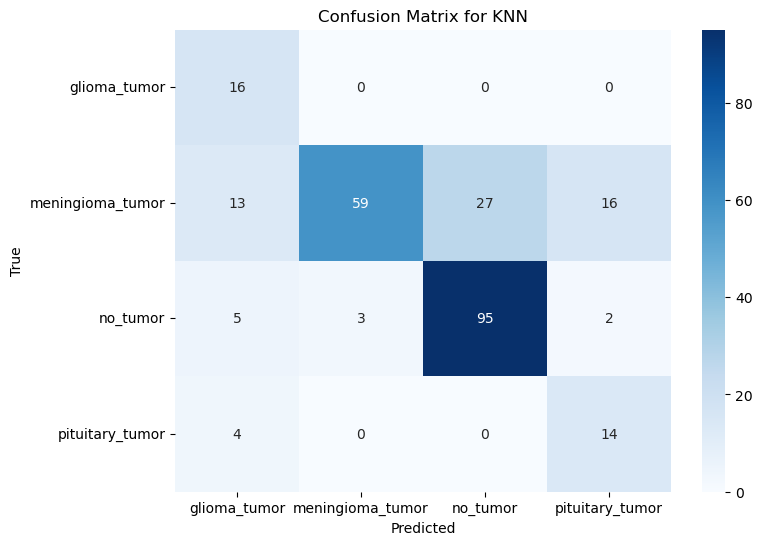

In [28]:
knn_pred = knn_best_model.predict(X_test_pca)
knn_cm = confusion_matrix(Y_test, knn_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for KNN')
plt.show()

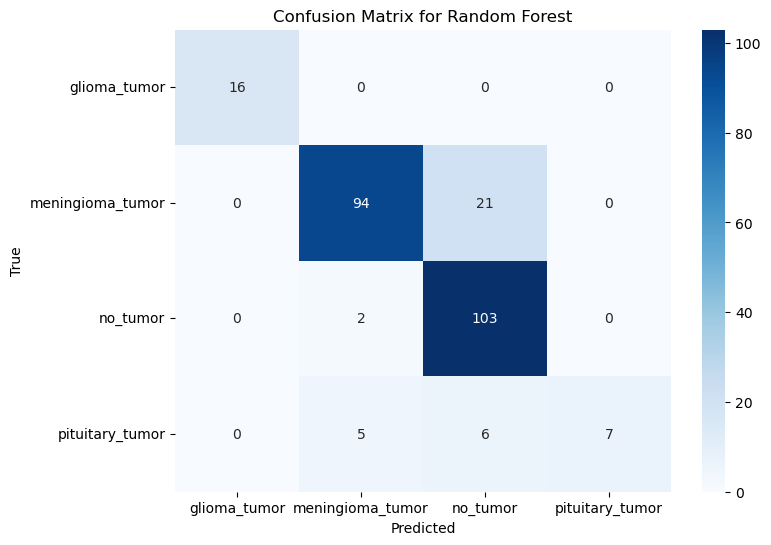

In [29]:
rf_cm = confusion_matrix(Y_test, rf_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Random Forest')
plt.show()

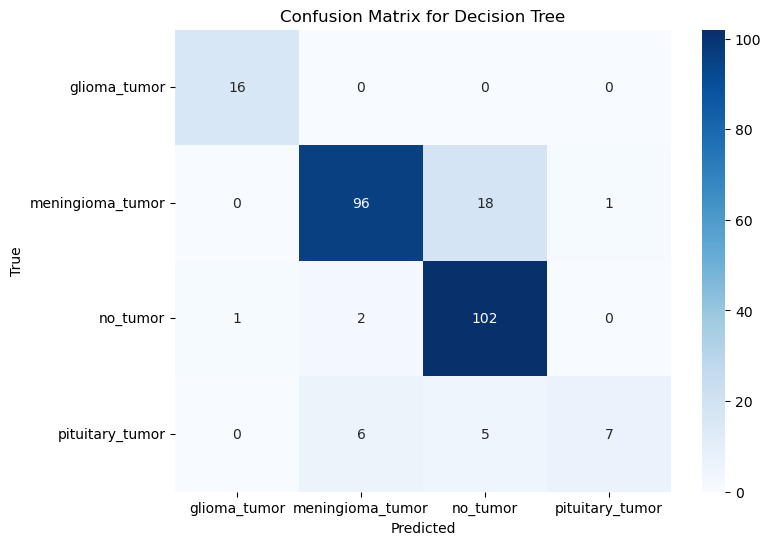

In [30]:
dt_cm = confusion_matrix(Y_test, dt_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(dt_cm, annot=True, fmt='d', cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Decision Tree')
plt.show()

In [32]:
import pickle

In [33]:
pickle.dump(model,open('model.pkl','wb'))